<a href="https://colab.research.google.com/github/Terryius/Reg_project/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A7%88%EC%9D%B4%EB%8B%9D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols 
plt.style.use('seaborn')
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from scipy import stats
#from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.decomposition import PCA
from scipy.stats import norm, skew

In [53]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [214]:
default_dir = "/content/gdrive/My Drive"
app_train = pd.read_csv(os.path.join(default_dir, 'FIFA_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir, 'FIFA_test.csv'))


def get_apps_dataset():
    default_dir = "/content/gdrive/My Drive"
    app_train = pd.read_csv(os.path.join(default_dir, 'FIFA_train.csv'))
    app_test = pd.read_csv(os.path.join(default_dir, 'FIFA_test.csv'))
    
    return app_train, app_test
(train, test) = get_apps_dataset()

## 1. 데이터 전처리

In [22]:
# 8932개의 데이터, 12개의 피처
# 결측치 없음
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [ ]:
# contract_util : 계약기간
# reputation : 평판
# stat_overall : 선수의 능력치
# stat_potential : 선수의 잠재능력
# stat_skill_moves : 선수의 개인기 능력치
# value : 선수의 이적 시장 가격

In [114]:
# id, name은 불필요하므로 삭제
# value가 이적료로 종속변수가 됨
# 연속형 자료 : ['age',	'stat_overall',	'stat_potential',	'value']
# 범주형/이산형 자료 : ['continent',	'contract_until',	'position',	'prefer_foot','reputation', 'stat_skill_moves' ]

train

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


In [215]:
# id, name 컬럼 삭제

train.drop(['id','name'], axis=1, inplace=True)
test.drop(['id','name'], axis=1, inplace=True)

In [ ]:
# 삭제된 것 확인
train.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


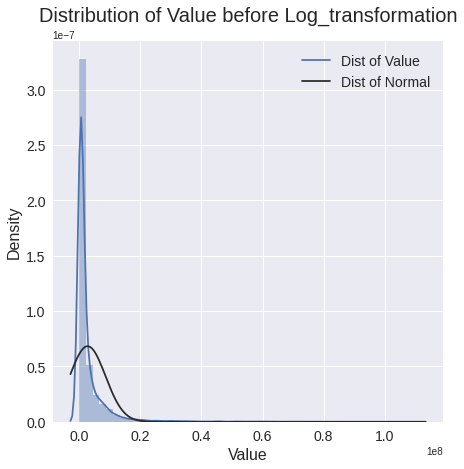

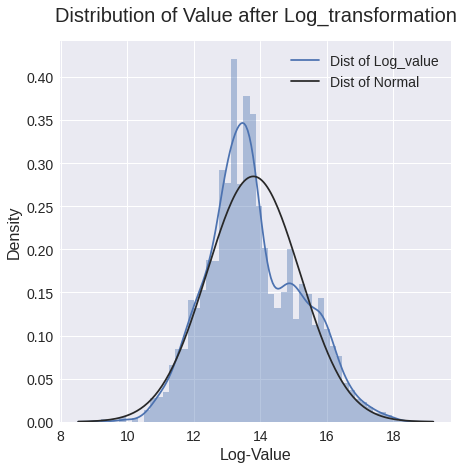

In [122]:
### 아래와 똑같은 plot 근데 이미지 따로 따로 복사하기 편하게 나눔:)

a = train['value']
b = np.log1p(train['value'])
plt.figure(figsize=(7,7))
c = sns.distplot(a, fit=norm)
c.set_title('Distribution of Value before Log_transformation', fontsize=20, pad=20)
c.set_xlabel('Value', fontsize=16)
c.set_ylabel('Density', fontsize=16)
c.tick_params(labelsize=14)
(mu, sigma) = norm.fit(a)
#plt.legend(['Dist of Value', 'Dist of Normal'], loc = 'best', fontsize=14)
c.legend(['Dist of Value', 'Dist of Normal'], loc = 'best', fontsize=14)
plt.show()
print('\n')

plt.figure(figsize=(7,7))
d = sns.distplot(b, fit=norm)
d.set_title('Distribution of Value after Log_transformation', fontsize=20, pad=20)
d.set_xlabel('Log-Value', fontsize=16)
d.set_ylabel('Density', fontsize=16)
d.tick_params(labelsize=14)
d.legend(['Dist of Log_value', 'Dist of Normal'], loc = 'best', fontsize=14)
plt.show()

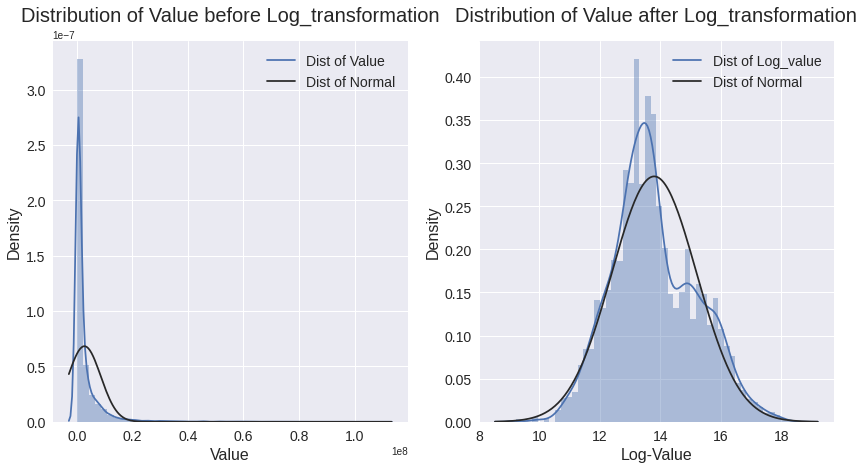

In [ ]:
### 위와 똑같은 plot 근데 이미지가 하나로 합쳐져 있음

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

a = train['value']
b = np.log1p(train['value'])
# plt.figure(figsize=(7,7))
c = sns.distplot(a, fit=norm, ax=axes[0])
c.set_title('Distribution of Value before Log_transformation', fontsize=20, pad=20)
c.set_xlabel('Value', fontsize=16)
c.set_ylabel('Density', fontsize=16)
c.tick_params(labelsize=14)
(mu, sigma) = norm.fit(a)
#plt.legend(['Dist of Value', 'Dist of Normal'], loc = 'best', fontsize=14)
c.legend(['Dist of Value', 'Dist of Normal'], loc = 'best', fontsize=14)
#plt.show()

#plt.figure(figsize=(7,7))
d = sns.distplot(b, fit=norm, ax=axes[1])
d.set_title('Distribution of Value after Log_transformation', fontsize=20, pad=20)
d.set_xlabel('Log-Value', fontsize=16)
d.set_ylabel('Density', fontsize=16)
d.tick_params(labelsize=14)
d.legend(['Dist of Log_value', 'Dist of Normal'], loc = 'best', fontsize=14)
plt.show()

\x

In [216]:
# 그냥 연속형 / 이산형 나눈 것.
cont = ['value',	'stat_overall',	'stat_potential',	'age']  
disc = ['continent','position',	'prefer_foot','reputation', 'stat_skill_moves', 'contract_until']  

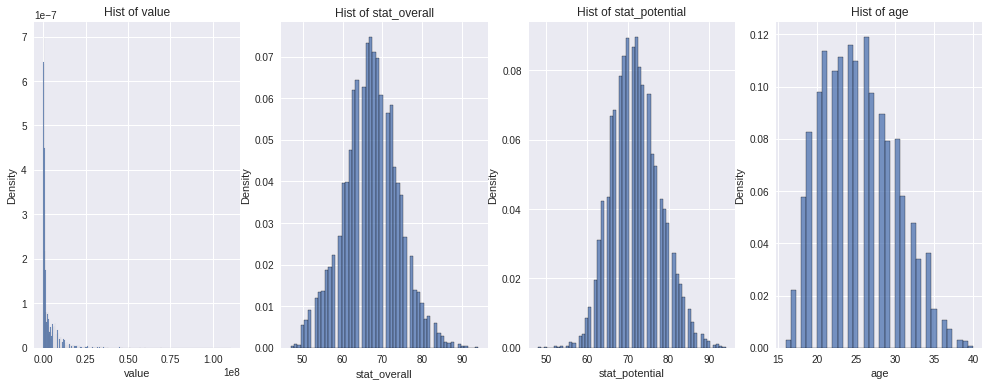

In [143]:
f, axes = plt.subplots(1,len(cont), figsize = (17,6))

for col, ax in zip(cont, axes) :
  a = sns.histplot(x = train[col], ax = ax , stat='density')
  a.set_title('Hist of {}'.format(col))
plt.show()

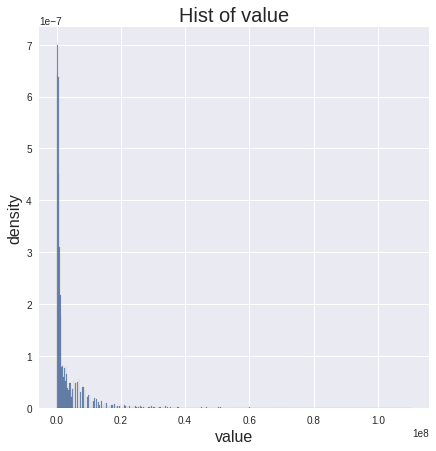

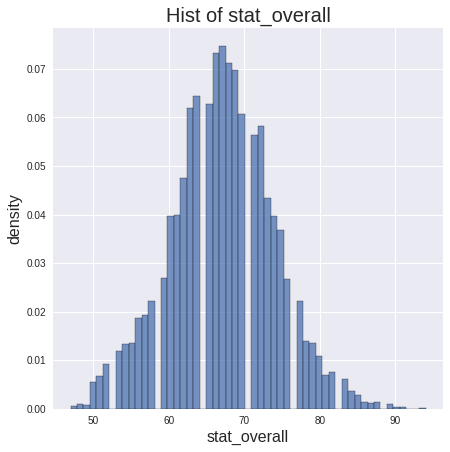

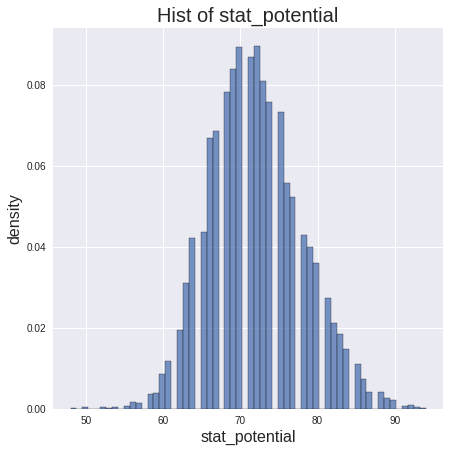

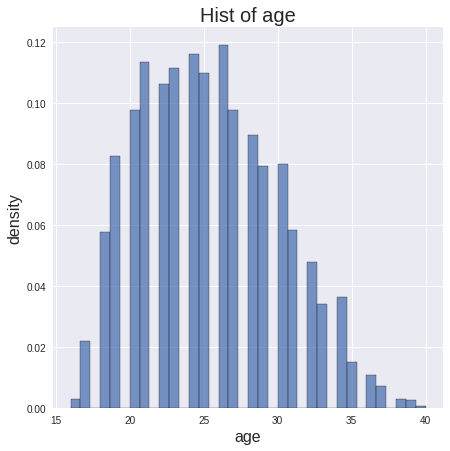

In [145]:
### 위와 똑같은 코드 복사하기 편하게 놔눔:)

for col in cont :
  plt.figure(figsize=(7,7))
  a = sns.histplot(x = train[col],  stat='density')
  a.set_title('Hist of {}'.format(col), fontsize=20)
  a.set_xlabel(col, fontsize=16)
  a.set_ylabel('density', fontsize=16)
  plt.show()
  print('\n')

In [ ]:
# Age 변수도 Log 변환시 더 좋아보임
print('Skewness before Log : ', skew(train['age']),'\n','Skewness after Log : ',skew(np.log1p(train['age'])))

Skewness before Log :  0.356764028481595 
 Skewness after Log :  0.018100653042745756


In [ ]:
# 범주형 변수들에 대해서 각각 가지는 unique 값 확인

for i in disc:
  print('{}:'.format(i), train[i].unique(), '\n')

# 계약기간 contract_until 이라는 변수에 대해서 전처리가 필요해보임
# 구체적으로는 년도를 기준으로 전처리 예정

continent: ['south america' 'europe' 'africa' 'asia' 'oceania'] 

position: ['ST' 'GK' 'DF' 'MF'] 

prefer_foot: ['left' 'right'] 

reputation: [5. 4. 3. 1. 2.] 

stat_skill_moves: [4. 1. 3. 2. 5.] 

contract_until: ['2021' '2020' '2019' '2023' '2022' '2024' 'Jun 30, 2019' '2026'
 'Dec 31, 2018' '2018' '2025' 'Jun 30, 2020' 'May 31, 2020' 'May 31, 2019'
 'Jan 31, 2019' 'Jan 1, 2019' 'Jan 12, 2019'] 



In [217]:
# 계약 연도만 추출하여 전처리 수행
def func(string: object) -> int:
    string = string[-4:]
    return int(string)


train['contract_until'] = train['contract_until'].apply(func)
test['contract_until'] = test['contract_until'].apply(func)

In [218]:
# 년도를 기준으로 범주가 잘 나눠짐을 확인할 수 있음
train.contract_until.value_counts()

# 근데 계약 기간이 2026년 까지인 선수가 한 명 밖에 존재하지 않아서 추후에 train / test 로 split할때 귀찮아 질수 있어서 2025에 합칠 예정

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

In [219]:
# 2026을 2025에 넣음
train.loc[train["contract_until"] == 2026, "contract_until"] = 2025
train.contract_until.value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       4
Name: contract_until, dtype: int64

In [149]:
# 범주형 변수들의 unique한 값들이 어떻게 분포되어 있는지 확인

for i in disc:
  print(train.loc[:, i].value_counts(), '\n')

europe           5322
south america    1927
asia              787
africa            721
oceania           175
Name: continent, dtype: int64 

MF    3428
DF    2791
ST    1705
GK    1008
Name: position, dtype: int64 

right    6837
left     2095
Name: prefer_foot, dtype: int64 

1.0    8014
2.0     706
3.0     177
4.0      31
5.0       4
Name: reputation, dtype: int64 

2.0    3905
3.0    3473
1.0    1008
4.0     515
5.0      31
Name: stat_skill_moves, dtype: int64 

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       4
Name: contract_until, dtype: int64 



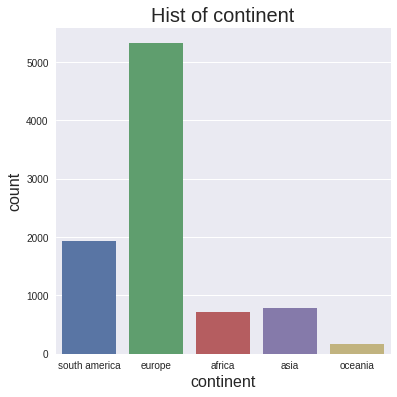

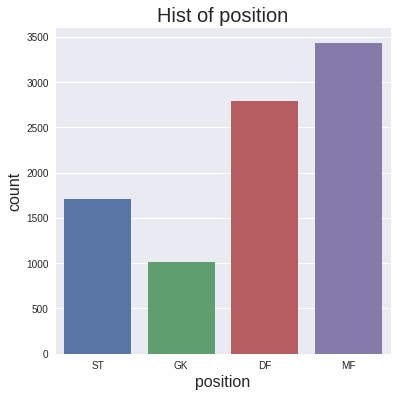

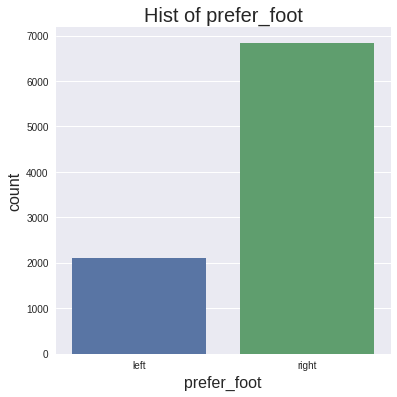

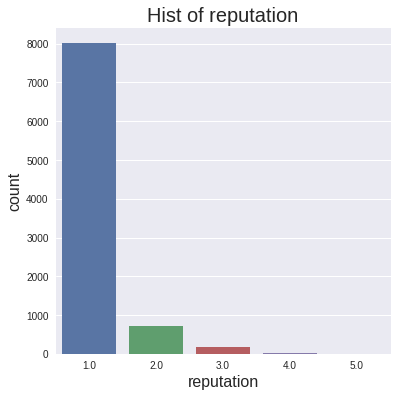

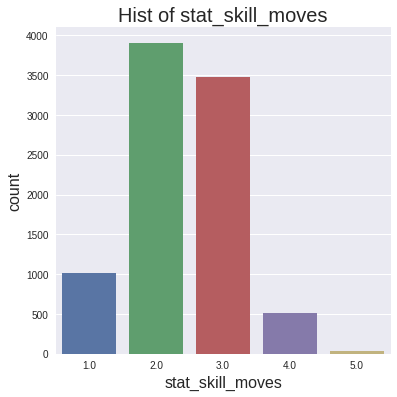

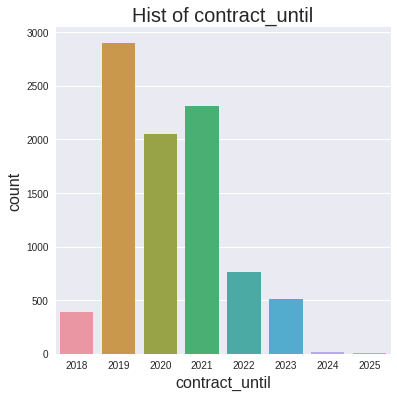

In [153]:
# 범주형 변수 히스토그램은 발표할 지 말지 고민 중
# 일단 간단하게 해놓음

for col in disc :
  plt.figure(figsize=(6,6))
  a = sns.countplot(data = train[disc], x = col)
  a.set_title('Hist of {}'.format(col), fontsize=20)
  a.set_xlabel(col, fontsize=16)
  a.set_ylabel('count', fontsize=16)
  plt.show()
  print('\n')

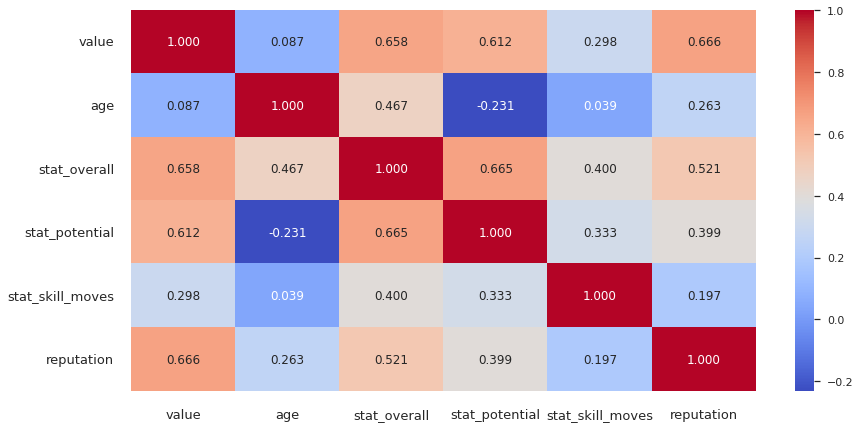

In [ ]:
# 변수간 상관관계  시각화

corr_df = train[['value','age','stat_overall','stat_potential','stat_skill_moves','reputation']].corr()

plt.figure(figsize=(14,7))
ax = sns.heatmap(corr_df, annot=True, fmt='.3f',cmap = 'coolwarm')
ax.tick_params(labelsize=13, length=10, width=3)
plt.show()

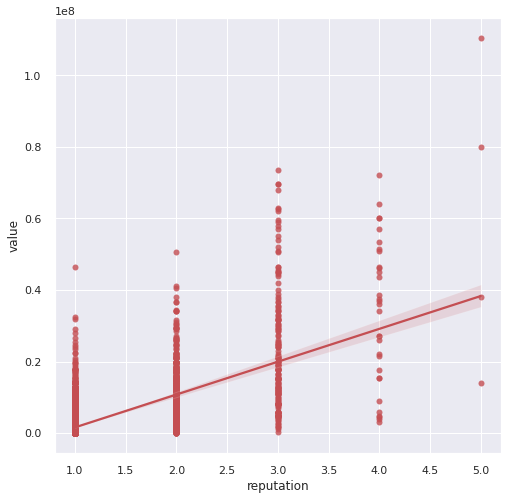

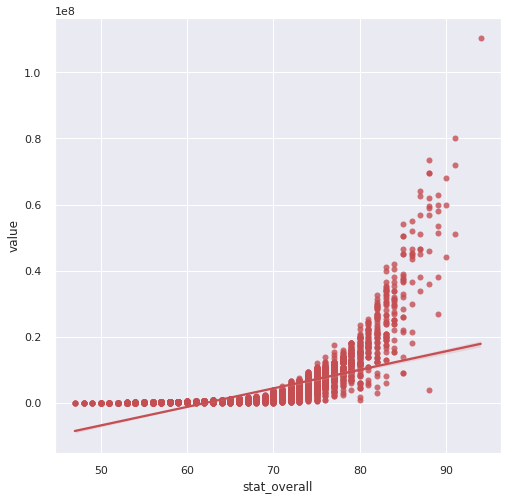

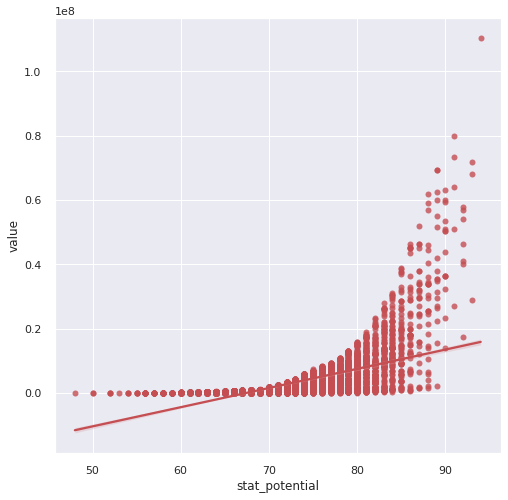

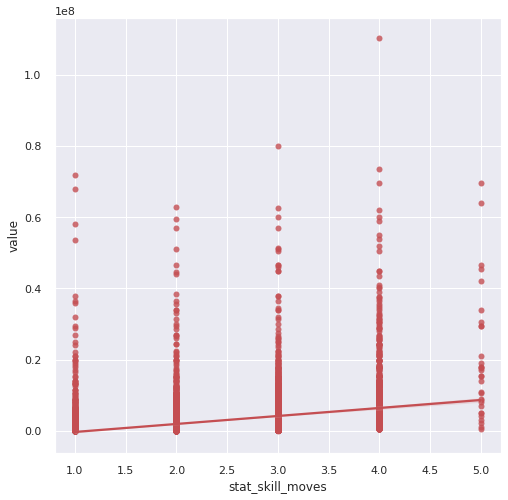

In [ ]:
# 상관관계를 확인 후 regplot으로 시각화
# 종속변수 value와 다음의 변수들이 어떠한 선형관계가 있는지를 시각적으로 확인
ft_name = ['reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']
sns.set(rc = {'figure.figsize':(8,8)})

for i, ft in enumerate(ft_name):
  sns.regplot(x=ft, y='value', data=train, color='r')
  plt.show()
  print('\n')

## 2. 데이터 분리, 더미변수화, 스케일링 등등

In [254]:
X = train.drop('value', axis = 1)
y = train[['value']]

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=22)

In [256]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6252, 9) (6252, 1) (2680, 9) (2680, 1)


In [257]:
X_train['continent'] = X_train['continent'].astype('category')
X_test['continent'] = X_test['continent'].astype('category')

X_train['position'] = X_train['position'].astype('category')
X_test['position'] = X_test['position'].astype('category')

X_train['prefer_foot'] = X_train['prefer_foot'].astype('category')
X_test['prefer_foot'] = X_test['prefer_foot'].astype('category')

X_train['stat_skill_moves'] = X_train['stat_skill_moves'].astype('category')
X_test['stat_skill_moves'] = X_test['stat_skill_moves'].astype('category')

X_train['reputation'] = X_train['reputation'].astype('category')
X_test['reputation'] = X_test['reputation'].astype('category')

X_train['contract_until'] = X_train['contract_until'].astype('category')
X_test['contract_until'] = X_test['contract_until'].astype('category')

In [223]:
# 일단 보류
X_train['continent'] = X_train['continent'].astype('category').cat.codes
X_test['continent'] = X_test['continent'].astype('category').cat.codes

X_train['position'] = X_train['position'].astype('category').cat.codes
X_test['position'] = X_test['position'].astype('category').cat.codes

X_train['prefer_foot'] = X_train['prefer_foot'].astype('category').cat.codes
X_test['prefer_foot'] = X_test['prefer_foot'].astype('category').cat.codes

X_train['stat_skill_moves'] = X_train['stat_skill_moves'].astype(int)
X_test['stat_skill_moves'] = X_test['stat_skill_moves'].astype(int)
X_train['reputation'] = X_train['reputation'].astype(int)
X_test['reputation'] = X_test['reputation'].astype(int)

In [243]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6252 entries, 5344 to 6276
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               6252 non-null   int64   
 1   continent         6252 non-null   category
 2   contract_until    6252 non-null   category
 3   position          6252 non-null   category
 4   prefer_foot       6252 non-null   category
 5   reputation        6252 non-null   category
 6   stat_overall      6252 non-null   int64   
 7   stat_potential    6252 non-null   int64   
 8   stat_skill_moves  6252 non-null   category
dtypes: category(6), int64(3)
memory usage: 233.3 KB


In [258]:
X_train = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot','reputation','stat_skill_moves','contract_until'], data = X_train)
X_test = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot','reputation','stat_skill_moves','contract_until'], data = X_test)

In [245]:
X_train.head()

,age,stat_overall,stat_potential,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,position_DF,position_GK,...,stat_skill_moves_4.0,stat_skill_moves_5.0,contract_until_2018,contract_until_2019,contract_until_2020,contract_until_2021,contract_until_2022,contract_until_2023,contract_until_2024,contract_until_2025
5344,19,66,74,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3703,24,68,71,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4097,25,68,73,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3175,26,69,72,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
181,30,82,82,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0


In [173]:
y_train

5344      900000.0
3703     1100000.0
4097      975000.0
3175      925000.0
181     21000000.0
           ...    
4587      675000.0
6646      425000.0
5478      775000.0
8548       90000.0
6276      350000.0
Name: value, Length: 6252, dtype: float64

In [259]:
X_train[['age']] = np.log1p(X_train[['age']])
X_test[['age']] = np.log1p(X_test[['age']])

y_train= np.log1p(y_train)
y_test = np.log1p(y_test)


In [247]:
scaler = StandardScaler()

scaled_train_x = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

scaled_test_x = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

## 3. 여러 모형으로 RMSE 등 비교

In [184]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [176]:
from sklearn.ensemble import RandomForestRegressor

In [261]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [262]:
rf_pred = rf.predict(X_test)

In [280]:
np.sqrt(mean_squared_error(np.expm1(rf_pred), np.expm1(y_test))) # 원래 값으로 변환 후 확인한 것

1380709.0846057427

In [278]:
rf = RandomForestRegressor(n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5-fold cv RMSE : {}'.format(avg_rmse))


5-fold cv RMSE : 0.1050499312892735


In [270]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

In [264]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [265]:
lr_pred = lr.predict(X_test)

In [266]:
mean_squared_error(lr_pred, y_test)

0.06940240866306868

In [268]:
import statsmodels.api as sm

new_y = np.expand_dims(y_train, axis=1)
m = sm.OLS(new_y, X_train)

result = m.fit()

result.summary()

In [276]:
## 릿지, 라쏘
alphas = [0.1, 0, 1, 10]
for alpha in alphas:
  ridge = Ridge(alpha).fit(X_train, y_train)
  ridge_pred = ridge.predict(X_test)
  print(f'MSE : {mean_squared_error(y_test, ridge_pred) : }')


MSE :  0.06941273173887424
MSE :  0.0693966109281606
MSE :  0.06951260773042177
MSE :  0.07194079565569489


In [277]:
alphas = [0.1, 0, 1, 10]
for alpha in alphas:
  lasso = Lasso(alpha).fit(X_train, y_train)
  lasso_pred = lasso.predict(X_test)
  print(f'MSE : {mean_squared_error(y_test, lasso_pred) : }')

MSE :  0.13708517543725032
MSE :  0.06940240866306858
MSE :  0.1638751652548019
MSE :  1.9794287023687245


In [ ]:
fifa["contract_until"] = fifa.contract_until.str.slice(-4,)
fifa.loc[fifa["contract_until"] == "2025", "contract_until"] = "2024"
fifa.loc[fifa["contract_until"] == "2026", "contract_until"] = "2024"
#fifa.loc[fifa["reputation"] == 5, "reputation"] = 4

In [ ]:
fifa2 = fifa.copy()
fifa2["age_group"] = [0]*len(fifa2)
fifa2.loc[(fifa["age"] >= 27)   & (fifa["age"] <= 32), "age_group"] = "A"
fifa2.loc[fifa["age"] < 27, "age_group"] = "B"
fifa2.loc[fifa["age"] > 32, "age_group"] = "C"
fifa2["age_group"] = fifa2["age_group"].astype("category")
fifa2['reputation'] = fifa2['reputation'].astype('category')
fifa2['stat_skill_moves'] = fifa2['stat_skill_moves'].astype('category')
fifa2['contract_until'] = fifa2['contract_until'].astype('category')
fifa2['continent'] = fifa2['continent'].astype('category')
fifa2['prefer_foot'] = fifa2['prefer_foot'].astype('category')
fifa2['position'] = fifa2['position'].astype('category')
dummy = pd.get_dummies(fifa2)
dummy.drop(['age'],axis=1 ,inplace=True)


In [ ]:
dummy.to_csv('age_group.csv', index=False)

In [ ]:
dummy

,stat_overall,stat_potential,value,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,contract_until_2018,contract_until_2019,contract_until_2020,contract_until_2021,contract_until_2022,contract_until_2023,contract_until_2024,position_DF,position_GK,position_MF,position_ST,prefer_foot_left,prefer_foot_right,reputation_1.0,reputation_2.0,reputation_3.0,reputation_4.0,reputation_5.0,stat_skill_moves_1.0,stat_skill_moves_2.0,stat_skill_moves_3.0,stat_skill_moves_4.0,stat_skill_moves_5.0,age_group_A,age_group_B,age_group_C
0,94,94,110500000.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,91,93,72000000.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
2,91,91,80000000.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
3,91,91,51000000.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
4,90,93,68000000.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,48,63,60000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0
8928,47,59,40000.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0
8929,47,64,50000.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0
8930,47,65,50000.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
x_train = dummy.columns.difference(['value'])
y  = dummy['value']
x = sm.add_constant(dummy[x_train])
y = np.log1p(y)
m = sm.OLS(y, x)
result = m.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.288e+04
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:43:34   Log-Likelihood:                 455.51
No. Observations:                8932   AIC:                            -859.0
Df Residuals:                    8906   BIC:                            -674.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
data.contract_until.unique()

array([2021, 2022, 2020, 2023, 2019, 2024, 2026, 2018, 2025])

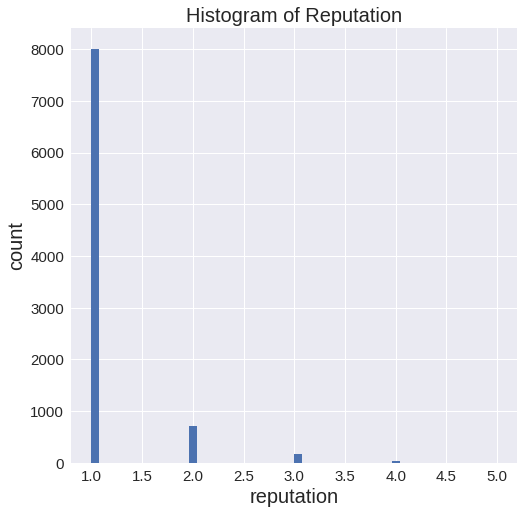

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(fifa.reputation, align='mid', bins=50)
ax.set_xlabel('reputation', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('Histogram of Reputation', fontsize=20)
ax.tick_params(labelsize=15)
plt.show()

In [ ]:
fifa.info()
# continent, position, prefer_foot, contract_until 은 명목변수 / 더미변수화 예정
# reputation, stat_skill_moves는 순위변수처럼 보이는데 연속형변수로 생각하고 적합할지, 더미변수로 적합해야 하는지 논의 필요
# id, name 과 같은 변수는 제거 예정
# 결측치는 보이지 않음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8932 non-null   int64 
 1   name              8932 non-null   object
 2   age               8932 non-null   int64 
 3   continent         8932 non-null   object
 4   contract_until    8932 non-null   int64 
 5   position          8932 non-null   object
 6   prefer_foot       8932 non-null   object
 7   reputation        8932 non-null   int64 
 8   stat_overall      8932 non-null   int64 
 9   stat_potential    8932 non-null   int64 
 10  stat_skill_moves  8932 non-null   int64 
 11  value             8932 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 837.5+ KB


In [ ]:
fifa.head(8)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5,94,94,4,110500000
1,7,L. Suárez,31,south america,2021,ST,right,5,91,91,3,80000000
2,30,Isco,26,europe,2022,ST,right,3,88,91,4,73500000
3,3,De Gea,27,europe,2020,GK,right,4,91,93,1,72000000
4,26,M. Salah,26,africa,2023,MF,left,3,88,89,4,69500000
5,32,Coutinho,26,south america,2023,ST,right,3,88,89,5,69500000
6,9,J. Oblak,25,europe,2021,GK,right,3,90,93,1,68000000
7,45,P. Pogba,25,europe,2021,MF,right,4,87,91,5,64000000


In [ ]:
fifa[fifa['contract_until'] == 2026]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
25,83,Saúl,23,europe,2026,MF,left,3,85,90,3,50500000


In [ ]:
# 범주형 변수들에 대해서 각각 가지는 unique 값 확인
name = ['continent', 'position', 'prefer_foot', 'reputation', 'stat_skill_moves', 'contract_until']
for i in name:
  print('{}:'.format(i), fifa[i].unique(), '\n')


continent: ['south america' 'europe' 'africa' 'asia' 'oceania'] 

position: ['ST' 'GK' 'MF' 'DF'] 

prefer_foot: ['left' 'right'] 

reputation: [5 3 4 2 1] 

stat_skill_moves: [4 3 1 5 2] 

contract_until: [2021 2022 2020 2023 2019 2024 2026 2018 2025] 



In [ ]:
# 범주형 변수들의 unique한 값들이 어떻게 분포되어 있는지 확인
name = ['continent', 'position', 'prefer_foot', 'reputation', 'stat_skill_moves','contract_until']

for i in name:
  print(fifa.loc[:, i].value_counts(), '\n')

europe           5322
south america    1927
asia              787
africa            721
oceania           175
Name: continent, dtype: int64 

MF    3428
DF    2791
ST    1705
GK    1008
Name: position, dtype: int64 

right    6837
left     2095
Name: prefer_foot, dtype: int64 

1    8014
2     706
3     177
4      31
5       4
Name: reputation, dtype: int64 

2    3905
3    3473
1    1008
4     515
5      31
Name: stat_skill_moves, dtype: int64 

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64 



In [ ]:
# 위의 범주형 변수들을 제외하고 나머지 변수들에 대해 기초통계량 확인
fifa[['age','stat_overall','stat_potential','value']].describe()

# value변수의 mean이 제 3사분위수 보다 큰 값으로 데이터가 right-skewed
# value변수에 대해서는 log변환이나 Box-Cox변환이 필요해 보임

,age,stat_overall,stat_potential,value
count,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,25.209136,67.091133,71.997201,2.778673e+06
std,4.635515,6.854910,5.988147,5.840982e+06
min,16.000000,47.000000,48.000000,1.000000e+04
25%,21.000000,63.000000,68.000000,3.750000e+05
50%,25.000000,67.000000,72.000000,8.250000e+05
75%,28.000000,72.000000,76.000000,2.600000e+06
max,40.000000,94.000000,94.000000,1.105000e+08


In [ ]:
from scipy.stats import norm, skew

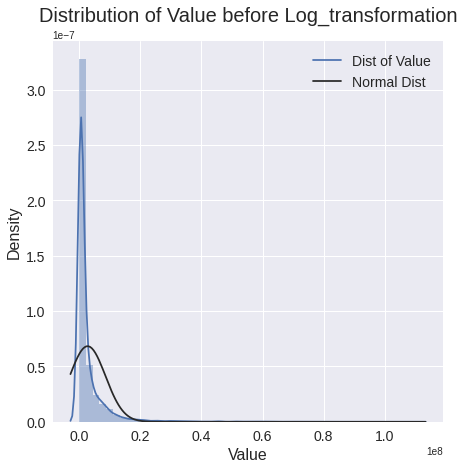

In [ ]:
# value변수에 대한 커널밀도추정으로 분포를 확인
a = fifa['value']
b = np.log1p(fifa['value'])
plt.figure(figsize=(7,7))
c = sns.distplot(a, fit=norm)
c.set_title('Distribution of Value before Log_transformation', fontsize=20, pad=20)
c.set_xlabel('Value', fontsize=16)
c.set_ylabel('Density', fontsize=16)
c.tick_params(labelsize=14)
(mu, sigma) = norm.fit(a)
plt.legend(['Dist of Value', 'Normal Dist'], loc = 'best', fontsize=14)
plt.show()

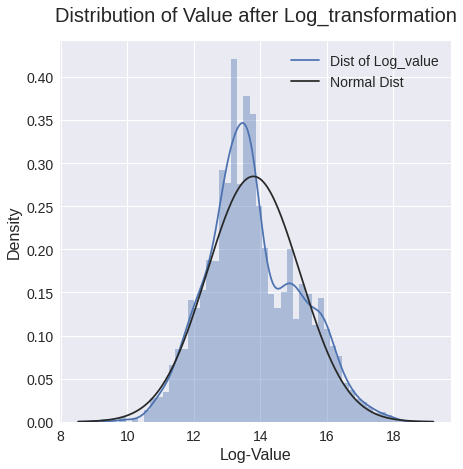

In [ ]:
plt.figure(figsize=(7,7))
c = sns.distplot(b, fit=norm)
c.set_title('Distribution of Value after Log_transformation', fontsize=20, pad=20)
c.set_xlabel('Log-Value', fontsize=16)
c.set_ylabel('Density', fontsize=16)
c.tick_params(labelsize=14)
plt.legend(['Dist of Log_value', 'Normal Dist'], loc = 'best', fontsize=14)
plt.show()

In [ ]:
# id, name 변수 제거 후, 잘 제거되었는지 확인
data = fifa.drop(['id', 'name'], axis=1)
data.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5,94,94,4,110500000
1,31,south america,2021,ST,right,5,91,91,3,80000000
2,26,europe,2022,ST,right,3,88,91,4,73500000
3,27,europe,2020,GK,right,4,91,93,1,72000000
4,26,africa,2023,MF,left,3,88,89,4,69500000


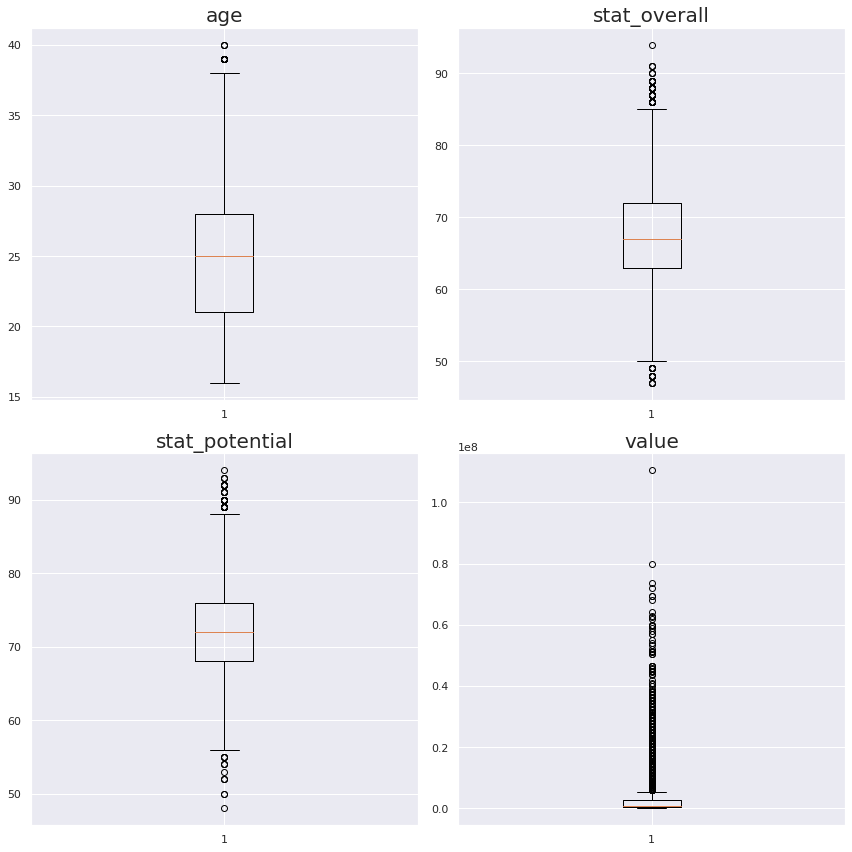

In [ ]:
# 연속형변수들에 대해 box-plot으로 outliers로 의심되는 값들 확인

b = ['age','stat_overall','stat_potential','value']
fig, axes = plt.subplots(2,2, figsize=(12,12))
for idx, ax in enumerate(axes.flat):
  ax.boxplot(data[b[idx]])
  ax.set_title(b[idx], size=20)
fig.tight_layout()

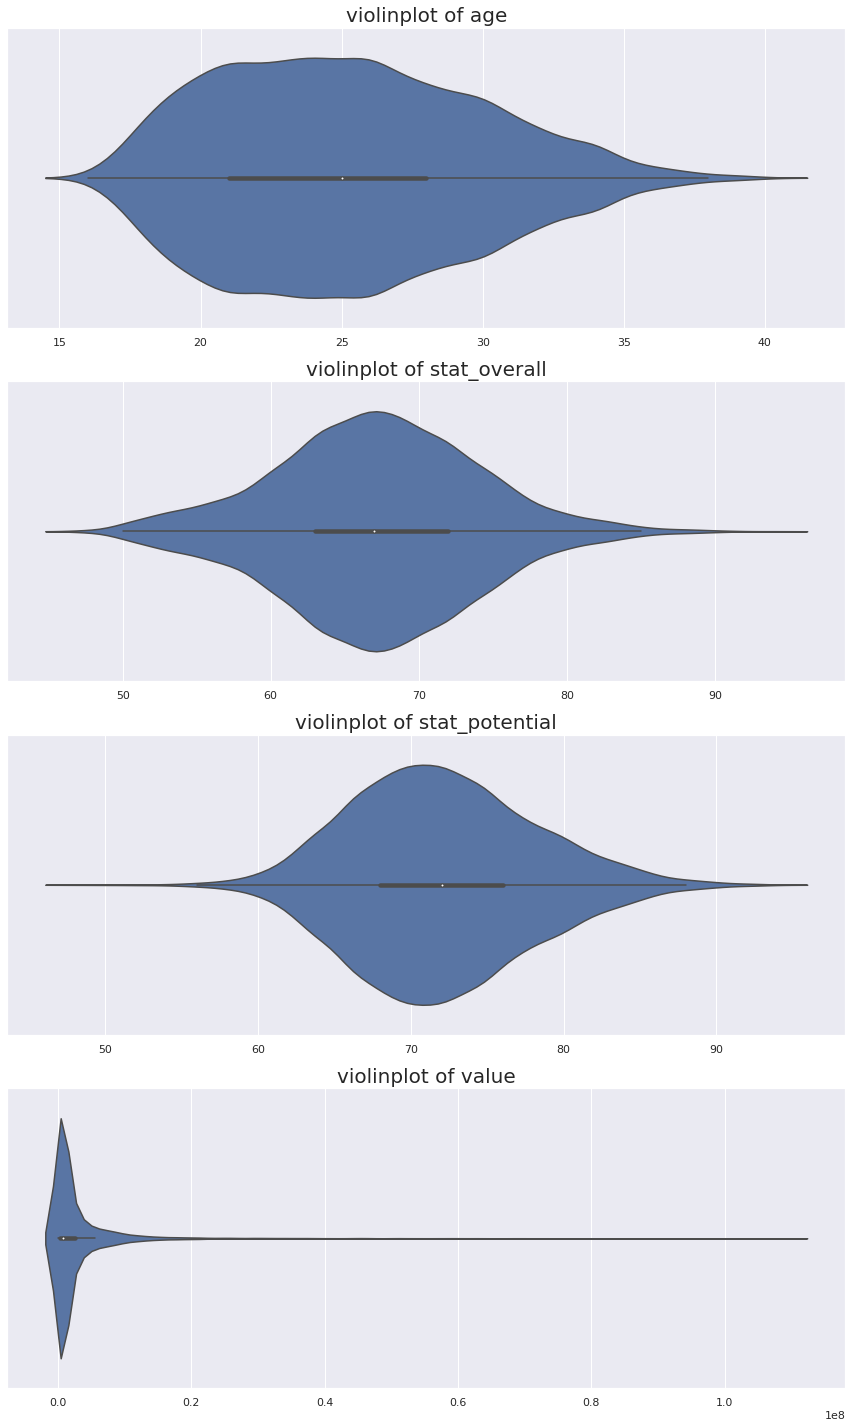

In [ ]:
# 위의 boxplot의 단점을 보완한 violinplot

ft_name = ['age', 'stat_overall', 'stat_potential', 'value' ]
sns.set(rc = {'figure.figsize':(12,20)})
fig, axs = plt.subplots(nrows = 4, ncols=1)
axs = axs.flat
for i,name in enumerate(ft_name):
  a = sns.violinplot(x=name, data=data, ax=axs[i])
  a.set_title('violinplot of {}'.format(name), fontsize=20)
  a.set_xlabel("")
fig.tight_layout()

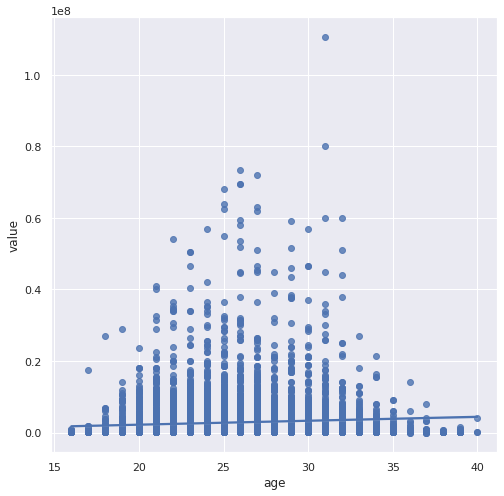

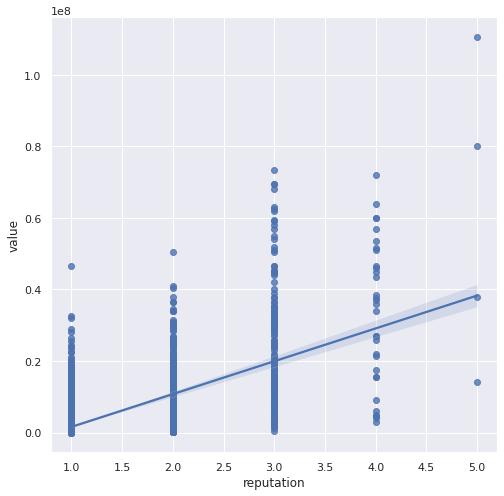

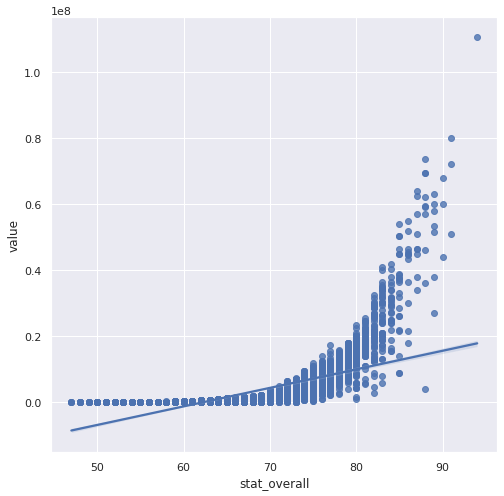

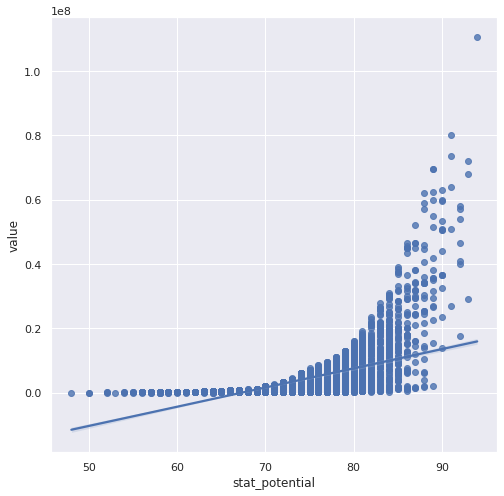

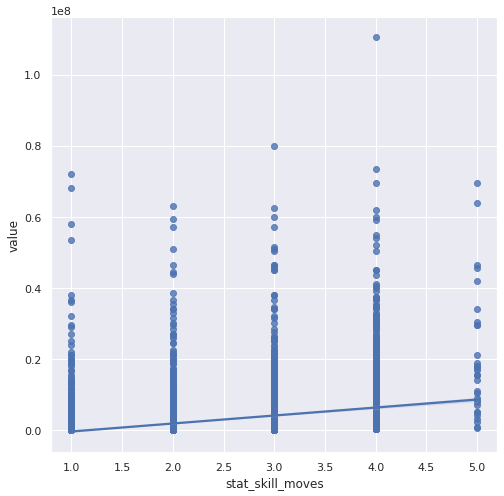

In [ ]:
# 종속변수 value와 다음의 변수들이 어떠한 선형관계가 있는지를 시각적으로 확안
ft_name = ['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']
sns.set(rc = {'figure.figsize':(8,8)})

for i, ft in enumerate(ft_name):
  sns.regplot(x=ft, y='value', data=data)
  plt.show()
  print('\n')

In [ ]:
# 변수간 상관관계 

corr_df = data[['stat_overall','stat_potential','value', 'stat_skill_moves', 'reputation', 'age']].corr()
corr_df

,stat_overall,stat_potential,value,stat_skill_moves,reputation,age
stat_overall,1.000000,0.665453,0.658444,0.400164,0.521389,0.467345
stat_potential,0.665453,1.000000,0.611907,0.332578,0.399183,-0.231303
value,0.658444,0.611907,1.000000,0.298500,0.665982,0.087319
stat_skill_moves,0.400164,0.332578,0.298500,1.000000,0.196582,0.039362
reputation,0.521389,0.399183,0.665982,0.196582,1.000000,0.263468
age,0.467345,-0.231303,0.087319,0.039362,0.263468,1.000000


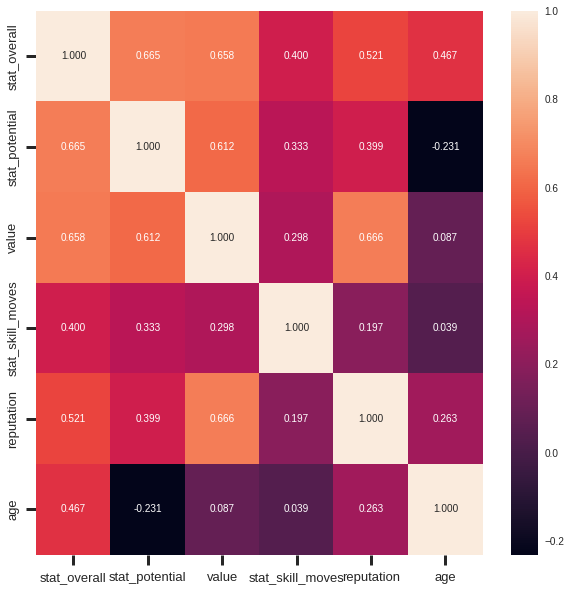

In [ ]:
# 변수간 상관관계  시각화

plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_df, annot=True, fmt='.3f')
ax.tick_params(labelsize=13, length=10, width=3)
plt.show()

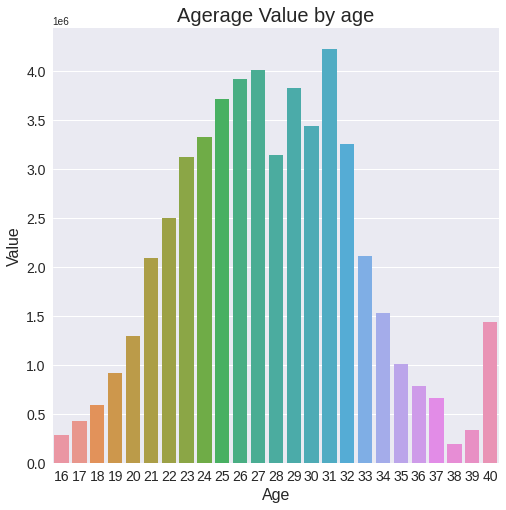

In [ ]:
plt.figure(figsize=(8,8))
a = sns.barplot(x='age', y='value',data=data, ci=None)
a.set_title('Agerage Value by age', fontsize=20)
a.set_xlabel('Age', fontsize=16)
a.set_ylabel('Value', fontsize=16)
a.tick_params(labelsize=14)

In [ ]:
data.groupby(['age'])['age'].count() # 16~24 / 25~32 / 32~40 ?? 

age
16     18
17    131
18    344
19    491
20    582
21    676
22    632
23    663
24    691
25    654
26    708
27    581
28    532
29    472
30    476
31    347
32    285
33    202
34    216
35     89
36     64
37     42
38     17
39     16
40      3
Name: age, dtype: int64

In [ ]:
copy3 = data.copy()
copy3['age'] = pd.cut(data['age'], 3)

In [ ]:
copy3.to_csv('copy3.csv', index=False)

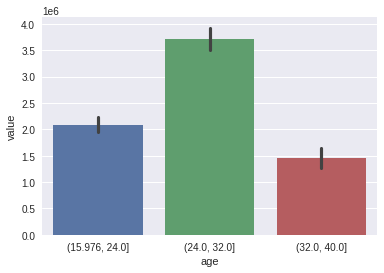

In [ ]:
sns.barplot(x='age', y='value', data=copy3)

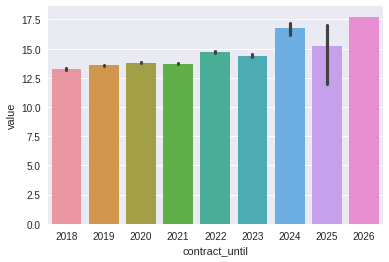

In [ ]:
sns.barplot(x='contract_until', y=np.log1p(copy3.value), data=copy3)

In [ ]:
contract_cut = data.copy()
contract_cut.drop(index = 25, inplace=True)
contract_cut

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5,94,94,4,110500000
1,31,south america,2021,ST,right,5,91,91,3,80000000
2,26,europe,2022,ST,right,3,88,91,4,73500000
3,27,europe,2020,GK,right,4,91,93,1,72000000
4,26,africa,2023,MF,left,3,88,89,4,69500000
...,...,...,...,...,...,...,...,...,...,...
8927,36,asia,2021,DF,right,1,57,57,2,10000
8928,37,asia,2021,GK,right,1,55,55,1,10000
8929,36,europe,2021,GK,right,1,53,53,1,10000
8930,37,europe,2018,GK,right,1,58,58,1,10000


In [ ]:
contract_cut = data.copy()
contract_cut.drop(index = 25, inplace=True)
contract_cut['contract_until'] = pd.cut(contract_cut['contract_until'], 4)
contract_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8931 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               8931 non-null   int64   
 1   continent         8931 non-null   object  
 2   contract_until    8931 non-null   category
 3   position          8931 non-null   object  
 4   prefer_foot       8931 non-null   object  
 5   reputation        8931 non-null   int64   
 6   stat_overall      8931 non-null   int64   
 7   stat_potential    8931 non-null   int64   
 8   stat_skill_moves  8931 non-null   int64   
 9   value             8931 non-null   int64   
dtypes: category(1), int64(6), object(3)
memory usage: 706.7+ KB


In [ ]:
contract_cut.head(15)

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,"(2019.75, 2021.5]",ST,left,5,94,94,4,110500000
1,31,south america,"(2019.75, 2021.5]",ST,right,5,91,91,3,80000000
2,26,europe,"(2021.5, 2023.25]",ST,right,3,88,91,4,73500000
3,27,europe,"(2019.75, 2021.5]",GK,right,4,91,93,1,72000000
4,26,africa,"(2021.5, 2023.25]",MF,left,3,88,89,4,69500000
5,26,south america,"(2021.5, 2023.25]",ST,right,3,88,89,5,69500000
6,25,europe,"(2019.75, 2021.5]",GK,right,3,90,93,1,68000000
7,25,europe,"(2019.75, 2021.5]",MF,right,4,87,91,5,64000000
8,27,europe,"(2021.5, 2023.25]",MF,right,3,89,90,2,63000000
9,25,europe,"(2021.5, 2023.25]",ST,left,3,87,89,3,62500000


In [ ]:
copy4 = data.copy()
copy4['age'] = pd.cut(data['age'], 5)
copy4.to_csv('copy4.csv', index=False)

In [ ]:
copy5 = data.copy()
copy5['age'] = pd.cut(data['age'], 2)
copy5.to_csv('copy5.csv', index=False)

In [ ]:
contract_cut = data.copy()
contract_cut.drop(index = 25, inplace=True)

In [ ]:
a = contract_cut[contract_cut['contract_until'] == 2018].replace(2018, '2018~2019')
b = contract_cut[contract_cut['contract_until'] == 2019].replace(2019, '2018~2019')
c = contract_cut[contract_cut['contract_until'] == 2020].replace(2020, '2020~2021')
d = contract_cut[contract_cut['contract_until'] == 2021].replace(2021, '2020~2021')
e = contract_cut[contract_cut['contract_until'] == 2022].replace(2022, '2022~2023')
f = contract_cut[contract_cut['contract_until'] == 2023].replace(2023, '2022~2023')
g = contract_cut[contract_cut['contract_until'] == 2024].replace(2024, '2024~2025')
h = contract_cut[contract_cut['contract_until'] == 2025].replace(2025, '2024~2025')
cc = pd.concat([a,b,c,d,e,f,g,h])

t = data.copy()

t[(t['contract_until'] == 2018) | (t['contract_until'] ==2019)  | (t['contract_until'] ==2020)| (t['contract_until'] ==2021)| (t['contract_until'] ==2022)| (t['contract_until'] ==2023)| (t['contract_until'] ==2024)| (t['contract_until'] ==2025)] = cc


In [ ]:
t[t.contract_until == 2026]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
25,23,europe,2026,MF,left,3,85,90,3,50500000


In [ ]:
t.drop(index=25, inplace=True)

In [ ]:
t

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2020~2021,ST,left,5,94,94,4,110500000
1,31,south america,2020~2021,ST,right,5,91,91,3,80000000
2,26,europe,2022~2023,ST,right,3,88,91,4,73500000
3,27,europe,2020~2021,GK,right,4,91,93,1,72000000
4,26,africa,2022~2023,MF,left,3,88,89,4,69500000
...,...,...,...,...,...,...,...,...,...,...
8927,36,asia,2020~2021,DF,right,1,57,57,2,10000
8928,37,asia,2020~2021,GK,right,1,55,55,1,10000
8929,36,europe,2020~2021,GK,right,1,53,53,1,10000
8930,37,europe,2018~2019,GK,right,1,58,58,1,10000


In [ ]:
copy3.contract_until.astype('object')

0       2021
1       2021
2       2022
3       2020
4       2023
        ... 
8927    2021
8928    2021
8929    2021
8930    2018
8931    2018
Name: contract_until, Length: 8932, dtype: object

In [ ]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               8932 non-null   int64 
 1   continent         8932 non-null   object
 2   contract_until    8932 non-null   object
 3   position          8932 non-null   object
 4   prefer_foot       8932 non-null   object
 5   reputation        8932 non-null   int64 
 6   stat_overall      8932 non-null   int64 
 7   stat_potential    8932 non-null   int64 
 8   stat_skill_moves  8932 non-null   int64 
 9   value             8932 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 697.9+ KB


In [ ]:
copy.to_csv('copy.csv', index=False)

In [ ]:
copy2 = data.copy()
copy2 = copy2.astype({'contract_until': object})

In [ ]:
copy2.contract_until

0       2021
1       2021
2       2022
3       2020
4       2023
        ... 
8927    2021
8928    2021
8929    2021
8930    2018
8931    2018
Name: contract_until, Length: 8932, dtype: object

In [ ]:
copy2.to_csv('copy2.csv', index=False)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               8932 non-null   int64 
 1   continent         8932 non-null   object
 2   contract_until    8932 non-null   int64 
 3   position          8932 non-null   object
 4   prefer_foot       8932 non-null   object
 5   reputation        8932 non-null   int64 
 6   stat_overall      8932 non-null   int64 
 7   stat_potential    8932 non-null   int64 
 8   stat_skill_moves  8932 non-null   int64 
 9   value             8932 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 697.9+ KB


In [ ]:
copy3['age'] = pd.cut(data['age'], 3)

In [ ]:
copy3 = data.copy()
copy3['age'] = pd.cut(data['age'], 3)

In [ ]:
t['age'] = pd.cut(t['age'], 3)

In [ ]:
# 'continent', 'position', 'prefer_foot', 'reputation','stat_skill_moves' 에 대해 더미변수화
name = ['continent', 'position', 'prefer_foot','age']
dummies = pd.get_dummies(t[name])#, drop_first=True)
fifa = pd.concat([t, dummies], axis=1).drop(name, axis=1)
final_df = pd.get_dummies(fifa, columns=['contract_until'])#, drop_first=True)  # 'reputation','stat_skill_moves',

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8931 entries, 0 to 8931
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   reputation                8931 non-null   int64
 1   stat_overall              8931 non-null   int64
 2   stat_potential            8931 non-null   int64
 3   stat_skill_moves          8931 non-null   int64
 4   value                     8931 non-null   int64
 5   continent_africa          8931 non-null   uint8
 6   continent_asia            8931 non-null   uint8
 7   continent_europe          8931 non-null   uint8
 8   continent_oceania         8931 non-null   uint8
 9   continent_south america   8931 non-null   uint8
 10  position_DF               8931 non-null   uint8
 11  position_GK               8931 non-null   uint8
 12  position_MF               8931 non-null   uint8
 13  position_ST               8931 non-null   uint8
 14  prefer_foot_left          8931 non-null 

In [ ]:
final_df.head()

,stat_overall,stat_potential,value,continent_asia,continent_europe,continent_oceania,continent_south america,position_GK,position_MF,position_ST,prefer_foot_right,"age_(24.0, 32.0]","age_(32.0, 40.0]",reputation_2.0,reputation_3.0,reputation_4.0,reputation_5.0,stat_skill_moves_2.0,stat_skill_moves_3.0,stat_skill_moves_4.0,stat_skill_moves_5.0,contract_until_2020~2021,contract_until_2022~2023,contract_until_2024~2025
0,94.0,94.0,110500000.0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
1,91.0,91.0,80000000.0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0
2,88.0,91.0,73500000.0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0
3,91.0,93.0,72000000.0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0
4,88.0,89.0,69500000.0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0


In [ ]:
final_df.columns

Index(['stat_overall', 'stat_potential', 'value', 'continent_asia',
       'continent_europe', 'continent_oceania', 'continent_south america',
       'position_GK', 'position_MF', 'position_ST', 'prefer_foot_right',
       'age_(24.0, 32.0]', 'age_(32.0, 40.0]', 'reputation_2', 'reputation_3',
       'reputation_4', 'reputation_5', 'stat_skill_moves_2',
       'stat_skill_moves_3', 'stat_skill_moves_4', 'stat_skill_moves_5',
       'contract_until_2020~2021', 'contract_until_2022~2023',
       'contract_until_2024~2025'],
      dtype='object')

In [ ]:
final_df

,value,continent_asia,continent_europe,continent_oceania,continent_south america,position_GK,position_MF,position_ST,prefer_foot_right,"age_(24.0, 32.0]","age_(32.0, 40.0]",reputation_2,reputation_3,reputation_4,reputation_5,stat_skill_moves_2,stat_skill_moves_3,stat_skill_moves_4,stat_skill_moves_5,contract_until_2020~2021,contract_until_2022~2023,contract_until_2024~2025,overall_potentail
0,110500000,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,94.0
1,80000000,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,91.0
2,73500000,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0,89.5
3,72000000,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,92.0
4,69500000,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,88.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,10000,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,57.0
8928,10000,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,55.0
8929,10000,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,53.0
8930,10000,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,58.0


In [ ]:
final_df.columns

Index(['reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves',
       'value', 'continent_africa', 'continent_asia', 'continent_europe',
       'continent_oceania', 'continent_south america', 'position_DF',
       'position_GK', 'position_MF', 'position_ST', 'prefer_foot_left',
       'prefer_foot_right', 'age_(15.976, 24.0]', 'age_(24.0, 32.0]',
       'age_(32.0, 40.0]', 'contract_until_2018~2019',
       'contract_until_2020~2021', 'contract_until_2022~2023',
       'contract_until_2024~2025'],
      dtype='object')

In [ ]:
name = final_df.columns.difference(['value'])
name

Index(['age_(15.976, 24.0]', 'age_(24.0, 32.0]', 'age_(32.0, 40.0]',
       'continent_africa', 'continent_asia', 'continent_europe',
       'continent_oceania', 'continent_south america',
       'contract_until_2018~2019', 'contract_until_2020~2021',
       'contract_until_2022~2023', 'contract_until_2024~2025', 'position_DF',
       'position_GK', 'position_MF', 'position_ST', 'prefer_foot_left',
       'prefer_foot_right', 'reputation', 'stat_overall', 'stat_potential',
       'stat_skill_moves'],
      dtype='object')

In [ ]:
a = 'stat_overall,stat_potential, value,continent_asia,continent_europe, continent_oceania, continent_south america,position_GK, position_MF, position_ST, prefer_foot_right,age_(24.0, 32.0], age_(32.0, 40.0], reputation_2, reputation_3,reputation_4,reputation_5, stat_skill_moves_2,stat_skill_moves_3, stat_skill_moves_4, stat_skill_moves_5,contract_until_2020~2021,contract_until_2022~2023,contract_until_2024~2025'
a.replace(',', '+')

'stat_overall+stat_potential+ value+continent_asia+continent_europe+ continent_oceania+ continent_south america+position_GK+ position_MF+ position_ST+ prefer_foot_right+age_(24.0+ 32.0]+ age_(32.0+ 40.0]+ reputation_2+ reputation_3+reputation_4+reputation_5+ stat_skill_moves_2+stat_skill_moves_3+ stat_skill_moves_4+ stat_skill_moves_5+contract_until_2020~2021+contract_until_2022~2023+contract_until_2024~2025'

In [ ]:
final_df.to_csv('final_df2.csv', index=False)

In [ ]:
import statsmodels.api as sm

In [ ]:
import statsmodels.api as sm
ft_name = ['stat_overall','stat_potential','continent_asia',
       'continent_europe', 'continent_oceania', 'continent_south america',
       'position_GK', 'position_MF', 'position_ST', 'prefer_foot_right',
       'age_(24.0, 32.0]', 'age_(32.0, 40.0]','reputation','stat_skill_moves' ,#'reputation_2', 'reputation_3',
       #'reputation_4', 'reputation_5', 'stat_skill_moves_2',
       #'stat_skill_moves_3', 'stat_skill_moves_4', 'stat_skill_moves_5',
       'contract_until_2020~2021','contract_until_2022~2023','contract_until_2024~2025']

x = final_df[name]

target_name = ['value']
y = final_df[target_name]

x = sm.add_constant(x)

m = sm.OLS(np.log1p(y), x)
result = m.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.785e+04
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:33:57   Log-Likelihood:                 198.24
No. Observations:                8931   AIC:                            -360.5
Df Residuals:                    8913   BIC:                            -232.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.5530      0.016    -35.551      0.000      -0.583      -0.522
age_(15.976, 24.0]           0.1520      0.009     17.806      0.000       0.135       0.169
age_(24.0, 32.0]             0.1199      0.007     17.926      0.000       0.107       0.133
age_(32.0, 40.0]            -0.8249      0.009    -92.752      0.000      -0.842      -0.807
continent_africa            -0.1040      0.009    -11.536      0.000      -0.122      -0.086
continent_asia              -0.1097      0.008    -13.416      0.000      -0.126      -0.094
continent_europe            -0.1137      0.006    -18.486      0.000      -0.126      -0.102
continent_oceania           -0.1107      0.015     -7.357      0.000      -0.140      -0.081
continent_south america     -0.1149      0.007    -16.028      0.000      -0.129      -0.101
contract_until_2018~2019    -0.1434      0.014     -9.989      0.000      -0.172      -0.115
contract_until_2020~2021    -0.1143      0.014     -7.974      0.000      -0.142      -0.086
contract_until_2022~2023    -0.1147      0.015     -7.549      0.000      -0.145      -0.085
contract_until_2024~2025    -0.1806      0.048     -3.757      0.000      -0.275      -0.086
position_DF                 -0.1990      0.006    -34.672      0.000      -0.210      -0.188
position_GK                 -0.2697      0.009    -28.625      0.000      -0.288      -0.251
position_MF                 -0.0710      0.006    -11.402      0.000      -0.083      -0.059
position_ST                 -0.0133      0.007     -1.909      0.056      -0.027       0.000
prefer_foot_left            -0.2808      0.009    -32.897      0.000      -0.298      -0.264
prefer_foot_right           -0.2722      0.008    -33.409      0.000      -0.288      -0.256
reputation                  -0.0222      0.007     -3.126      0.002      -0.036      -0.008
stat_overall                 0.1633      0.001    190.660      0.000       0.162       0.165
stat_potential               0.0533      0.001     59.916      0.000       0.052       0.055
stat_skill_moves             0.0600      0.005     11.253      0.000       0.050       0.070
==============================================================================
Omnibus:                     2481.954   Durbin-Watson:                   0.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20746.588
Skew:                          -1.095   Prob(JB):                         0.00
Kurtosis:                      10.138   Cond. No.                     3.94e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.62e-28. This might indicate that there are
strong multi

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(m.exog, i)} 
             for i, column in enumerate(m.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,const,0.000000
1,"age_(15.976, 24.0]",inf
2,"age_(24.0, 32.0]",inf
3,"age_(32.0, 40.0]",inf
4,continent_africa,inf
5,continent_asia,inf
6,continent_europe,inf
7,continent_oceania,inf
8,continent_south america,inf
9,contract_until_2018~2019,inf


In [ ]:
name = data.columns.difference(['value', 'contract_until', 'continent', 'prefer_foot', 'position'])
x = data[name]

target_name = ['value']
y = data[target_name]

x = sm.add_constant(x)

m = sm.OLS(y, x)
result = m.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     3233.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:20:26   Log-Likelihood:            -1.4722e+05
No. Observations:                8932   AIC:                         2.945e+05
Df Residuals:                    8926   BIC:                         2.945e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.506e+07   6.76e+05    -37.086      0.000   -2.64e+07   -2.37e+07
age               -4.17e+05   1.63e+04    -25.621      0.000   -4.49e+05   -3.85e+05
reputation        6.282e+06   1.04e+05     60.561      0.000    6.08e+06    6.49e+06
stat_overall       5.22e+05   1.45e+04     35.891      0.000    4.93e+05     5.5e+05
stat_potential   -5.099e+04   1.48e+04     -3.448      0.001      -8e+04    -2.2e+04
stat_skill_moves -4.377e+04    5.3e+04     -0.826      0.409   -1.48e+05    6.01e+04
==============================================================================
Omnibus:                     9246.199   Durbin-Watson:                   0.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1428004.461
Skew:                           4.827   Prob(JB):                         0.00
Kurtosis:                      64.187   Cond. No.                     1.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

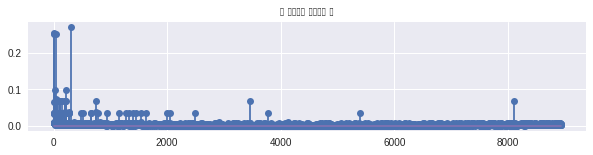

In [ ]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
#plt.axhline(0.02, c="g", ls="--")
plt.title("각 데이터의 레버리지 값")
plt.show()

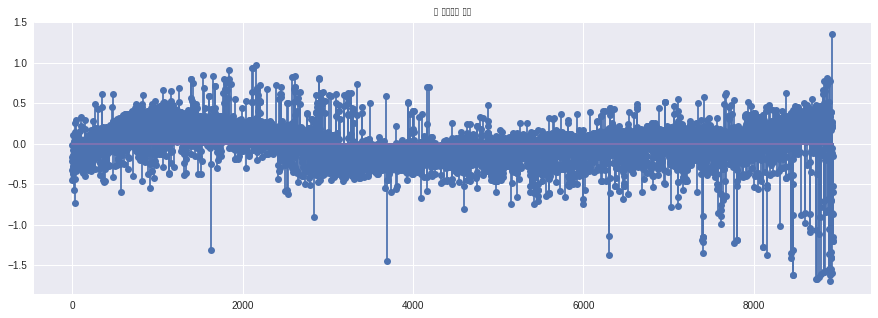

In [ ]:
plt.figure(figsize=(15, 5))
plt.stem(result.resid)
plt.title("각 데이터의 잔차")
plt.show()

KeyboardInterrupt: ignored

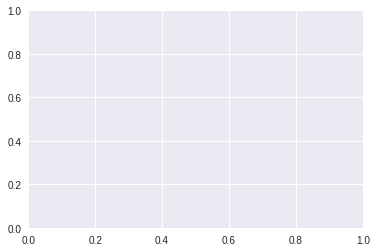

In [ ]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

In [ ]:
ft_name = ['stat_overall', 'stat_potential','continent_asia',
       'continent_europe', 'continent_oceania', 'continent_south america',
       'position_GK', 'position_MF', 'position_ST', 'prefer_foot_right',
       'age_(24.0, 32.0]', 'age_(32.0, 40.0]', 'reputation_2', 'reputation_3',
       'reputation_4', 'reputation_5', 'stat_skill_moves_2',
       'stat_skill_moves_3', 'stat_skill_moves_4', 'stat_skill_moves_5',
       'contract_until_2019', 'contract_until_2020', 'contract_until_2021',
       'contract_until_2022', 'contract_until_2023', 'contract_until_2024',
       'contract_until_2025', 'contract_until_2026']
x = final_df[ft_name]

target_name = ['value']
y = final_df[target_name]

x = sm.add_constant(x)

m = sm.OLS(np.log1p(y), x)
result = m.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.251e+04
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:54:57   Log-Likelihood:                 328.13
No. Observations:                8932   AIC:                            -604.3
Df Residuals:                    8906   BIC:                            -419.7
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.7963      0.038    -21.174      0.000      -0.870      -0.723
stat_overall                0.1631      0.001    192.466      0.000       0.161       0.165
stat_potential              0.0531      0.001     60.411      0.000       0.051       0.055
continent_asia             -0.0101      0.012     -0.819      0.413      -0.034       0.014
continent_europe           -0.0091      0.009     -0.971      0.331      -0.027       0.009
continent_oceania          -0.0026      0.020     -0.131      0.896      -0.041       0.036
continent_south america    -0.0083      0.010     -0.803      0.422      -0.029       0.012
position_GK                -0.3276      0.012    -27.404      0.000      -0.351      -0.304
position_MF                 0.1329      0.007     19.958      0.000       0.120       0.146
position_ST                 0.1896      0.008     24.118      0.000       0.174       0.205
prefer_foot_right           0.0075      0.006      1.253      0.210      -0.004       0.019
age_(24.0, 32.0]           -0.0337      0.009     -3.946      0.000      -0.050      -0.017
age_(32.0, 40.0]           -0.9850      0.013    -77.068      0.000      -1.010      -0.960
reputation_2                0.0656      0.010      6.345      0.000       0.045       0.086
reputation_3               -0.0917      0.019     -4.714      0.000      -0.130      -0.054
reputation_4               -0.3902      0.043     -9.027      0.000      -0.475      -0.305
reputation_5               -0.7062      0.118     -5.986      0.000      -0.937      -0.475
stat_skill_moves_2         -0.1957      0.010    -19.490      0.000      -0.215      -0.176
stat_skill_moves_3         -0.1585      0.011    -14.079      0.000      -0.181      -0.136
stat_skill_moves_4         -0.0357      0.015     -2.405      0.016      -0.065      -0.007
stat_skill_moves_5         -0.0788      0.037     -2.136      0.033      -0.151      -0.006
contract_until_2019        -0.0115      0.013     -0.900      0.368      -0.037       0.014
contract_until_2020         0.0075      0.013      0.567      0.571      -0.018       0.033
contract_until_2021         0.0328      0.013      2.531      0.011       0.007       0.058
contract_until_2022         0.0362      0.015      2.409      0.016       0.007       0.066
contract_until_2023        -0.0157      0.016     -0.982      0.326      -0.047       0.016
contract_until_2024~       -0.0368      0.060     -0.611      0.541      -0.155       0.081
==============================================================================
Omnibus:                     2546.320   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22559.126
Skew:                          -1.112   Prob(JB):                         0.00
Kurtosi

In [ ]:
influence = result.get_influence()
influence


In [ ]:
# IQR 기준 이상치 검정
def get_outliers(df=None, col=None):
  test = df[col]
  q25 = np.percentile(test, 25)
  q75 = np.percentile(test, 75)
  iqr = q75-q25
  iqr_weight = iqr*1.5
  min = q25 - iqr_weight
  max = q75 + iqr_weight
  outlier_idx = test[(test<min) | (test>max)].index
  return outlier_idx

In [ ]:
# IQR 기준 이상치 검정
a = np.log1p(data[['value']])

q25 = np.percentile(a, 25)
q75 = np.percentile(a, 75)
iqr = q75-q25
iqr_weight = iqr*1.5
min = q25 - iqr_weight
max = q75 + iqr_weight
outlier = a[(a<min) | (a>max)]
outlier_idx = a[(a<min) | (a>max)].index


In [ ]:
copy3['log_value'] = np.log1p(copy3.value)

In [ ]:
copy3[(copy3['log_value'] > q75)].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220],
           dtype='int64', length=2221)

In [ ]:
min

9.930176347628617

In [ ]:
max

17.675530011594063

In [ ]:
l1 = a[a < min].groupby('value')['value'].count()
l2 = a[a > max].groupby('value')['value'].count()

In [ ]:
a[a==9.210440]

value    0.0
dtype: float64

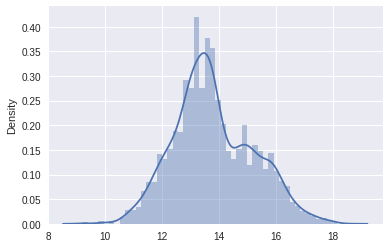

In [ ]:
sns.distplot(a)


In [ ]:
name = ['age','stat_overall','stat_potential']

for i in range(3):
  print(get_outliers(data, name[i]))
  

Int64Index([1627, 2914, 3698, 4165, 6305, 7402, 7403, 7406, 8112, 8159, 8440,
            8459, 8460, 8740, 8825, 8887, 8891, 8892, 8913],
           dtype='int64')
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
              11,   12,   13,   14,   15,   16,   17,   18,   20,   21,   22,
              23,   24,   27,   29,   30,   31,   32,   34,   35,   37,   38,
              39,   47,   48,   54,   56,   66,   86,  103,  150,  212, 1627,
            8786, 8814, 8815, 8816, 8823, 8838, 8861, 8862, 8863, 8864, 8865,
            8873, 8874, 8883, 8884, 8899, 8920],
           dtype='int64')
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   11,
              12,   13,   15,   16,   18,   19,   20,   22,   23,   24,   25,
              26,   28,   38,   40,   41,   43,   47,   52,   53,   55,   57,
              58,   59,   70,   76,   88,   94,  102,  103,  107,  134,  137,
             215,  258,  302, 2538, 8636, 8747, 8828, 8877

In [ ]:
# 'continent', 'position', 'prefer_foot', 'reputation','stat_skill_moves' 에 대해 더미변수화
name = ['continent', 'position', 'prefer_foot','contract_until']
dummies = pd.get_dummies(copy[name], drop_first=True)
fifa = pd.concat([copy, dummies], axis=1).drop(name, axis=1)
final_df = pd.get_dummies(fifa, columns=['reputation','stat_skill_moves'], drop_first=True)

In [ ]:
# 각각의 범주의 수에 맞게 더미변수화 된 것을 확인할 수 있음
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      8932 non-null   int64
 1   stat_overall             8932 non-null   int64
 2   stat_potential           8932 non-null   int64
 3   value                    8932 non-null   int64
 4   continent_asia           8932 non-null   uint8
 5   continent_europe         8932 non-null   uint8
 6   continent_oceania        8932 non-null   uint8
 7   continent_south america  8932 non-null   uint8
 8   position_GK              8932 non-null   uint8
 9   position_MF              8932 non-null   uint8
 10  position_ST              8932 non-null   uint8
 11  prefer_foot_right        8932 non-null   uint8
 12  contract_until_2019      8932 non-null   uint8
 13  contract_until_2020      8932 non-null   uint8
 14  contract_until_2021      8932 non-null   uint8
 15  cont

In [ ]:
# apps.to_csv('FIFA.csv')